In [1]:
import tensorflow as tf
from keras.layers import Conv1D, MaxPooling1D, Dropout, Dense, Concatenate, GlobalAveragePooling1D, BatchNormalization, ReLU
import joblib
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

sns.set_style('darkgrid')

2023-07-17 00:39:32.211633: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
X_train_scaled = joblib.load('./preprocessed/X_train_scaled.joblib')
Y_train_scaled = joblib.load('./preprocessed/Y_train_scaled.joblib')
Z_train = joblib.load('./preprocessed/Z_train.joblib')
X_val_scaled = joblib.load('./preprocessed/X_val_scaled.joblib')
Y_val_scaled = joblib.load('./preprocessed/Y_val_scaled.joblib')
Z_val = joblib.load('./preprocessed/Z_val.joblib')
X_test_scaled = joblib.load('./preprocessed/X_test_scaled.joblib')
Y_test_scaled = joblib.load('./preprocessed/Y_test_scaled.joblib')
Z_test = joblib.load('./preprocessed/Z_test.joblib')

In [6]:
X_train_scaled = joblib.load('./preprocessed/X_train_scaled.joblib')

X_train_scaled.shape


(17441, 7)

In [5]:
# X model

X_input = tf.keras.layers.Input(X_train_scaled.shape[1:])

X = Dense(128, activation='relu')(X_input)
X = Dropout(0.3)(X)
X = Dense(128, activation='relu')(X)
X = Dropout(0.3)(X)
X = Dense(64, activation='relu')(X)
X = Dropout(0.3)(X)
X = Dense(32, activation='relu')(X)
output = Dense(Z_train.shape[-1], activation='sigmoid')(X)

modelX = tf.keras.Model(inputs=X_input, outputs=output)



In [6]:
modelX.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['binary_accuracy', 'Precision', 'Recall']
)

modelX.fit(
    X_train_scaled, Z_train, epochs = 40, batch_size=32, validation_data=(X_val_scaled, Z_val)
)

Epoch 1/40
546/546 [==============================] - 2s 2ms/step - loss: 0.5107 - binary_accuracy: 0.7666 - precision: 0.6022 - recall: 0.2481 - val_loss: 0.4988 - val_binary_accuracy: 0.7677 - val_precision: 0.5777 - val_recall: 0.3396
Epoch 2/40
546/546 [==============================] - 1s 1ms/step - loss: 0.4850 - binary_accuracy: 0.7807 - precision: 0.6362 - recall: 0.3256 - val_loss: 0.4966 - val_binary_accuracy: 0.7702 - val_precision: 0.5876 - val_recall: 0.3386
Epoch 3/40
546/546 [==============================] - 1s 1ms/step - loss: 0.4800 - binary_accuracy: 0.7853 - precision: 0.6487 - recall: 0.3438 - val_loss: 0.4904 - val_binary_accuracy: 0.7745 - val_precision: 0.6126 - val_recall: 0.3204
Epoch 4/40
546/546 [==============================] - 1s 1ms/step - loss: 0.4762 - binary_accuracy: 0.7871 - precision: 0.6568 - recall: 0.3448 - val_loss: 0.4885 - val_binary_accuracy: 0.7771 - val_precision: 0.6154 - val_recall: 0.3414
Epoch 5/40
546/546 [============================

In [7]:
# Y model

# interpretation: returns a tuple of dimension 1 and 2, so (5000, 12)
Y_input = tf.keras.layers.Input(Y_train_scaled.shape[1:])

Y = Conv1D(128, 3, padding='same')(Y_input)
Y = BatchNormalization()(Y)
Y = ReLU()(Y)
Y = MaxPooling1D(2)(Y)

Y = Conv1D(128, 3, padding='same')(Y)
Y = BatchNormalization()(Y)
Y = ReLU()(Y)
Y = MaxPooling1D(2)(Y)

Y = Conv1D(64, 3, padding='same')(Y)
Y = BatchNormalization()(Y)
Y = ReLU()(Y)

Y = GlobalAveragePooling1D()(Y)

Y = Dropout(0.3)(Y)


In [8]:
Z = Concatenate()([output, Y])
Z = Dense(64, activation='relu')(Z)
Z = Dense(64, activation='relu')(Z)
Z = Dropout(0.4)(Z)
output = Dense(Z_train.shape[-1], activation="sigmoid")(Z)

modelZ = tf.keras.Model(inputs=[X_input, Y_input], outputs=output)

In [9]:
modelZ.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['binary_accuracy', 'Precision', 'Recall']
)

modelZ.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 5000, 12)]   0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 5000, 128)    4736        ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 5000, 128)   512         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 re_lu (ReLU)                   (None, 5000, 128)    0           ['batch_normalization[0][0]

In [10]:
callback = [
    tf.keras.callbacks.ModelCheckpoint(monitor='val_binary_accuracy', save_best_only=True, filepath='./models'),
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=20),
    tf.keras.callbacks.TensorBoard(log_dir='./logs')
]

history = modelZ.fit(
    [X_train_scaled, Y_train_scaled], Z_train, epochs=100, batch_size=32, callbacks=callback, validation_data=([X_val_scaled, Y_val_scaled], Z_val)
)

Epoch 1/100
545/546 [============================>.] - ETA: 0s - loss: 0.4251 - binary_accuracy: 0.8099 - precision: 0.6879 - recall: 0.4652

INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


546/546 [==============================] - 173s 313ms/step - loss: 0.4251 - binary_accuracy: 0.8099 - precision: 0.6879 - recall: 0.4652 - val_loss: 0.3656 - val_binary_accuracy: 0.8410 - val_precision: 0.7701 - val_recall: 0.5391
Epoch 2/100
545/546 [============================>.] - ETA: 0s - loss: 0.3685 - binary_accuracy: 0.8433 - precision: 0.7498 - recall: 0.5781

INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


546/546 [==============================] - 165s 302ms/step - loss: 0.3685 - binary_accuracy: 0.8433 - precision: 0.7498 - recall: 0.5781 - val_loss: 0.3547 - val_binary_accuracy: 0.8500 - val_precision: 0.7524 - val_recall: 0.6158
Epoch 3/100
545/546 [============================>.] - ETA: 0s - loss: 0.3533 - binary_accuracy: 0.8516 - precision: 0.7603 - recall: 0.6100

INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


546/546 [==============================] - 155s 283ms/step - loss: 0.3533 - binary_accuracy: 0.8516 - precision: 0.7603 - recall: 0.6100 - val_loss: 0.3567 - val_binary_accuracy: 0.8505 - val_precision: 0.7582 - val_recall: 0.6097
Epoch 4/100
545/546 [============================>.] - ETA: 1s - loss: 0.3424 - binary_accuracy: 0.8583 - precision: 0.7753 - recall: 0.6251

INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


546/546 [==============================] - 684s 1s/step - loss: 0.3424 - binary_accuracy: 0.8583 - precision: 0.7753 - recall: 0.6251 - val_loss: 0.3378 - val_binary_accuracy: 0.8599 - val_precision: 0.7674 - val_recall: 0.6486
Epoch 5/100
545/546 [============================>.] - ETA: 0s - loss: 0.3346 - binary_accuracy: 0.8634 - precision: 0.7844 - recall: 0.6398

INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


546/546 [==============================] - 150s 275ms/step - loss: 0.3346 - binary_accuracy: 0.8634 - precision: 0.7843 - recall: 0.6398 - val_loss: 0.3298 - val_binary_accuracy: 0.8669 - val_precision: 0.7843 - val_recall: 0.6614
Epoch 6/100
545/546 [============================>.] - ETA: 0s - loss: 0.3305 - binary_accuracy: 0.8638 - precision: 0.7844 - recall: 0.6418

INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


546/546 [==============================] - 142s 260ms/step - loss: 0.3305 - binary_accuracy: 0.8638 - precision: 0.7844 - recall: 0.6418 - val_loss: 0.3210 - val_binary_accuracy: 0.8683 - val_precision: 0.7961 - val_recall: 0.6518
Epoch 7/100
546/546 [==============================] - 139s 255ms/step - loss: 0.3223 - binary_accuracy: 0.8677 - precision: 0.7903 - recall: 0.6544 - val_loss: 0.3214 - val_binary_accuracy: 0.8679 - val_precision: 0.7903 - val_recall: 0.6575
Epoch 8/100
546/546 [==============================] - 141s 259ms/step - loss: 0.3193 - binary_accuracy: 0.8705 - precision: 0.7956 - recall: 0.6621 - val_loss: 0.3186 - val_binary_accuracy: 0.8664 - val_precision: 0.7973 - val_recall: 0.6400
Epoch 9/100
545/546 [============================>.] - ETA: 0s - loss: 0.3148 - binary_accuracy: 0.8702 - precision: 0.7932 - recall: 0.6637

INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


546/546 [==============================] - 142s 260ms/step - loss: 0.3148 - binary_accuracy: 0.8702 - precision: 0.7932 - recall: 0.6637 - val_loss: 0.3095 - val_binary_accuracy: 0.8718 - val_precision: 0.8002 - val_recall: 0.6643
Epoch 10/100
546/546 [==============================] - 141s 259ms/step - loss: 0.3116 - binary_accuracy: 0.8725 - precision: 0.7968 - recall: 0.6706 - val_loss: 0.3128 - val_binary_accuracy: 0.8700 - val_precision: 0.7998 - val_recall: 0.6557
Epoch 11/100
545/546 [============================>.] - ETA: 0s - loss: 0.3062 - binary_accuracy: 0.8750 - precision: 0.8003 - recall: 0.6789

INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


546/546 [==============================] - 144s 263ms/step - loss: 0.3062 - binary_accuracy: 0.8750 - precision: 0.8003 - recall: 0.6789 - val_loss: 0.3093 - val_binary_accuracy: 0.8730 - val_precision: 0.7945 - val_recall: 0.6786
Epoch 12/100
546/546 [==============================] - 140s 256ms/step - loss: 0.3068 - binary_accuracy: 0.8762 - precision: 0.8040 - recall: 0.6796 - val_loss: 0.3088 - val_binary_accuracy: 0.8715 - val_precision: 0.7941 - val_recall: 0.6714
Epoch 13/100
546/546 [==============================] - 139s 254ms/step - loss: 0.3003 - binary_accuracy: 0.8771 - precision: 0.8041 - recall: 0.6846 - val_loss: 0.3227 - val_binary_accuracy: 0.8706 - val_precision: 0.7903 - val_recall: 0.6721
Epoch 14/100
546/546 [==============================] - 139s 254ms/step - loss: 0.2989 - binary_accuracy: 0.8780 - precision: 0.8053 - recall: 0.6872 - val_loss: 0.3086 - val_binary_accuracy: 0.8722 - val_precision: 0.7911 - val_recall: 0.6796
Epoch 15/100
545/546 [===============

INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


546/546 [==============================] - 141s 258ms/step - loss: 0.2952 - binary_accuracy: 0.8793 - precision: 0.8077 - recall: 0.6906 - val_loss: 0.3153 - val_binary_accuracy: 0.8747 - val_precision: 0.7848 - val_recall: 0.7025
Epoch 16/100
545/546 [============================>.] - ETA: 0s - loss: 0.2938 - binary_accuracy: 0.8801 - precision: 0.8071 - recall: 0.6961

INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


546/546 [==============================] - 140s 256ms/step - loss: 0.2938 - binary_accuracy: 0.8801 - precision: 0.8071 - recall: 0.6960 - val_loss: 0.3007 - val_binary_accuracy: 0.8762 - val_precision: 0.8017 - val_recall: 0.6850
Epoch 17/100
545/546 [============================>.] - ETA: 0s - loss: 0.2920 - binary_accuracy: 0.8810 - precision: 0.8098 - recall: 0.6964

INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


546/546 [==============================] - 139s 254ms/step - loss: 0.2920 - binary_accuracy: 0.8810 - precision: 0.8098 - recall: 0.6964 - val_loss: 0.2956 - val_binary_accuracy: 0.8793 - val_precision: 0.8073 - val_recall: 0.6935
Epoch 18/100
546/546 [==============================] - 138s 252ms/step - loss: 0.2878 - binary_accuracy: 0.8832 - precision: 0.8126 - recall: 0.7039 - val_loss: 0.2963 - val_binary_accuracy: 0.8784 - val_precision: 0.7959 - val_recall: 0.7053
Epoch 19/100
546/546 [==============================] - 139s 255ms/step - loss: 0.2882 - binary_accuracy: 0.8827 - precision: 0.8129 - recall: 0.7009 - val_loss: 0.2957 - val_binary_accuracy: 0.8791 - val_precision: 0.8001 - val_recall: 0.7025
Epoch 20/100
546/546 [==============================] - 139s 254ms/step - loss: 0.2836 - binary_accuracy: 0.8841 - precision: 0.8137 - recall: 0.7072 - val_loss: 0.3021 - val_binary_accuracy: 0.8779 - val_precision: 0.7802 - val_recall: 0.7271
Epoch 21/100
546/546 [===============

INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


546/546 [==============================] - 141s 258ms/step - loss: 0.2828 - binary_accuracy: 0.8856 - precision: 0.8182 - recall: 0.7083 - val_loss: 0.2936 - val_binary_accuracy: 0.8816 - val_precision: 0.8150 - val_recall: 0.6946
Epoch 23/100
546/546 [==============================] - 139s 255ms/step - loss: 0.2819 - binary_accuracy: 0.8864 - precision: 0.8206 - recall: 0.7095 - val_loss: 0.2931 - val_binary_accuracy: 0.8813 - val_precision: 0.7994 - val_recall: 0.7149
Epoch 24/100
545/546 [============================>.] - ETA: 0s - loss: 0.2801 - binary_accuracy: 0.8860 - precision: 0.8183 - recall: 0.7103

INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


546/546 [==============================] - 142s 260ms/step - loss: 0.2801 - binary_accuracy: 0.8860 - precision: 0.8183 - recall: 0.7103 - val_loss: 0.2944 - val_binary_accuracy: 0.8816 - val_precision: 0.8040 - val_recall: 0.7100
Epoch 25/100
546/546 [==============================] - 140s 257ms/step - loss: 0.2781 - binary_accuracy: 0.8879 - precision: 0.8211 - recall: 0.7160 - val_loss: 0.2944 - val_binary_accuracy: 0.8806 - val_precision: 0.8042 - val_recall: 0.7046
Epoch 26/100
546/546 [==============================] - 140s 256ms/step - loss: 0.2783 - binary_accuracy: 0.8879 - precision: 0.8219 - recall: 0.7150 - val_loss: 0.2943 - val_binary_accuracy: 0.8790 - val_precision: 0.8015 - val_recall: 0.7000
Epoch 27/100
546/546 [==============================] - 139s 255ms/step - loss: 0.2779 - binary_accuracy: 0.8880 - precision: 0.8224 - recall: 0.7149 - val_loss: 0.2985 - val_binary_accuracy: 0.8783 - val_precision: 0.7844 - val_recall: 0.7228
Epoch 28/100
546/546 [===============

INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


546/546 [==============================] - 141s 258ms/step - loss: 0.2703 - binary_accuracy: 0.8915 - precision: 0.8300 - recall: 0.7222 - val_loss: 0.2928 - val_binary_accuracy: 0.8817 - val_precision: 0.8010 - val_recall: 0.7149
Epoch 36/100
546/546 [==============================] - 140s 256ms/step - loss: 0.2699 - binary_accuracy: 0.8908 - precision: 0.8295 - recall: 0.7194 - val_loss: 0.2974 - val_binary_accuracy: 0.8779 - val_precision: 0.8007 - val_recall: 0.6953
Epoch 37/100
546/546 [==============================] - 139s 254ms/step - loss: 0.2671 - binary_accuracy: 0.8928 - precision: 0.8321 - recall: 0.7259 - val_loss: 0.2954 - val_binary_accuracy: 0.8812 - val_precision: 0.8061 - val_recall: 0.7046
Epoch 38/100
546/546 [==============================] - 139s 255ms/step - loss: 0.2696 - binary_accuracy: 0.8918 - precision: 0.8309 - recall: 0.7226 - val_loss: 0.3003 - val_binary_accuracy: 0.8798 - val_precision: 0.8059 - val_recall: 0.6978
Epoch 39/100
546/546 [===============

INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


546/546 [==============================] - 141s 258ms/step - loss: 0.2664 - binary_accuracy: 0.8916 - precision: 0.8318 - recall: 0.7201 - val_loss: 0.2936 - val_binary_accuracy: 0.8830 - val_precision: 0.8038 - val_recall: 0.7174
Epoch 41/100
546/546 [==============================] - 139s 254ms/step - loss: 0.2634 - binary_accuracy: 0.8942 - precision: 0.8357 - recall: 0.7277 - val_loss: 0.2926 - val_binary_accuracy: 0.8825 - val_precision: 0.7974 - val_recall: 0.7246
Epoch 42/100
546/546 [==============================] - 139s 254ms/step - loss: 0.2638 - binary_accuracy: 0.8937 - precision: 0.8334 - recall: 0.7285 - val_loss: 0.2929 - val_binary_accuracy: 0.8803 - val_precision: 0.8046 - val_recall: 0.7021
Epoch 43/100
546/546 [==============================] - 139s 254ms/step - loss: 0.2631 - binary_accuracy: 0.8943 - precision: 0.8337 - recall: 0.7311 - val_loss: 0.3025 - val_binary_accuracy: 0.8795 - val_precision: 0.7913 - val_recall: 0.7182
Epoch 44/100
546/546 [===============

INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


546/546 [==============================] - 140s 256ms/step - loss: 0.2534 - binary_accuracy: 0.8986 - precision: 0.8418 - recall: 0.7414 - val_loss: 0.2914 - val_binary_accuracy: 0.8835 - val_precision: 0.8109 - val_recall: 0.7100
Epoch 58/100
546/546 [==============================] - 138s 252ms/step - loss: 0.2531 - binary_accuracy: 0.8986 - precision: 0.8425 - recall: 0.7407 - val_loss: 0.2965 - val_binary_accuracy: 0.8815 - val_precision: 0.8020 - val_recall: 0.7125
Epoch 59/100
546/546 [==============================] - 139s 254ms/step - loss: 0.2536 - binary_accuracy: 0.8993 - precision: 0.8441 - recall: 0.7419 - val_loss: 0.2983 - val_binary_accuracy: 0.8782 - val_precision: 0.8032 - val_recall: 0.6932
Epoch 60/100
546/546 [==============================] - 137s 252ms/step - loss: 0.2520 - binary_accuracy: 0.8995 - precision: 0.8459 - recall: 0.7403 - val_loss: 0.2936 - val_binary_accuracy: 0.8818 - val_precision: 0.8008 - val_recall: 0.7157
Epoch 61/100
546/546 [===============

INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


546/546 [==============================] - 140s 256ms/step - loss: 0.2433 - binary_accuracy: 0.9023 - precision: 0.8485 - recall: 0.7504 - val_loss: 0.2989 - val_binary_accuracy: 0.8844 - val_precision: 0.8081 - val_recall: 0.7182
Epoch 77/100
546/546 [==============================] - 139s 255ms/step - loss: 0.2448 - binary_accuracy: 0.9015 - precision: 0.8484 - recall: 0.7472 - val_loss: 0.2991 - val_binary_accuracy: 0.8824 - val_precision: 0.8003 - val_recall: 0.7192
Epoch 78/100
546/546 [==============================] - 137s 251ms/step - loss: 0.2422 - binary_accuracy: 0.9032 - precision: 0.8480 - recall: 0.7555 - val_loss: 0.3016 - val_binary_accuracy: 0.8815 - val_precision: 0.7949 - val_recall: 0.7232
Epoch 79/100
546/546 [==============================] - 137s 251ms/step - loss: 0.2418 - binary_accuracy: 0.9035 - precision: 0.8503 - recall: 0.7541 - val_loss: 0.2999 - val_binary_accuracy: 0.8814 - val_precision: 0.7932 - val_recall: 0.7253
Epoch 80/100
546/546 [===============

In [11]:
detection_model = tf.keras.models.load_model('./models')

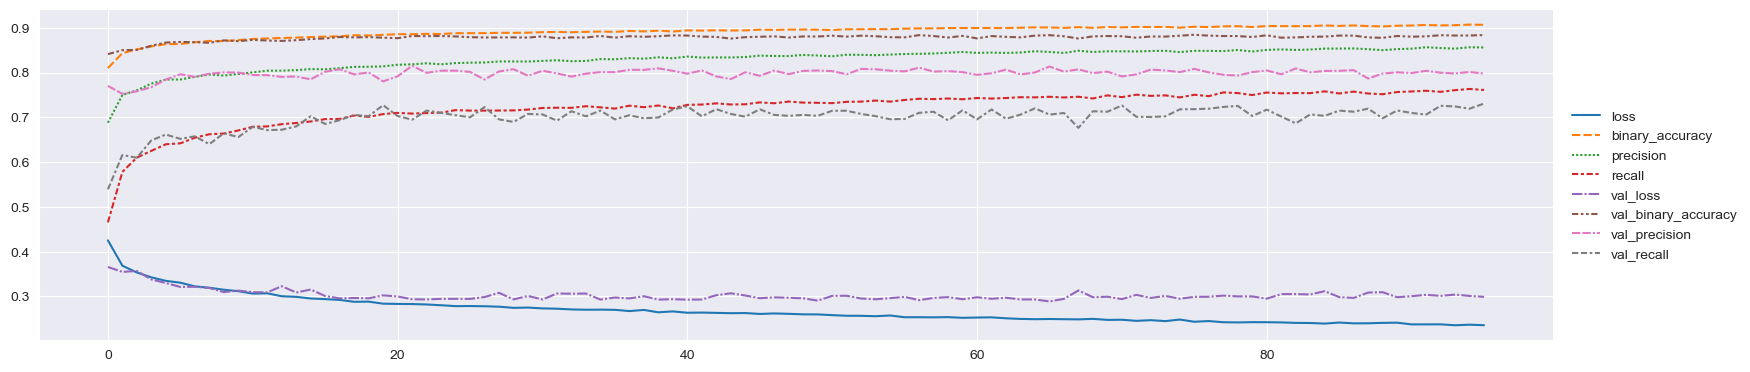

In [19]:
sns.relplot(data=pd.DataFrame(history.history), kind='line', height=4, aspect=4)
plt.show()

In [20]:
detection_model.evaluate([X_test_scaled, Y_test_scaled], Z_test)

69/69 [==============================] - 5s 61ms/step - loss: 0.2964 - binary_accuracy: 0.8827 - precision: 0.8076 - recall: 0.7072


[0.29638826847076416,
 0.8827052712440491,
 0.8075825572013855,
 0.7072474360466003]